<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-1/blob/main/multiclass_StackOverflowCuestions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clasificación de varias clases
En el primer cuaderno de introducción trabajé con un tutorial de clasificación binaria, en este cuaderno trabajaré con un dataset de lenguajes de programación de stack Overflow.

El objetivo consistirá en clasificar entre los distintos lenguajes, el dataset se encuentra en el siguiente enlace:
 [dataset](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb#scrollTo=hKY4XMc9o8iB)
Para realizar el ejercicio se ha tachado el nombre de los lenguajes de programación:

  s (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). 

Organizaré el dataset de la siguiente forma:
Dataset/
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
test/
...python/
......2.txt
......3.txt
...javascript/
......3.txt
......4.txt
...csharp/
......5.txt
......6.txt
...java/
......7.txt
......9.txt


In [45]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, we recommend reading [this guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.


In [67]:
os.mkdir('StackOverflow')

In [68]:
cd 'StackOverflow'

/content/StackOverflow/StackOverflow/StackOverflow/StackOverflow


In [69]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stackOverflow", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stackOverflow')

6053888/6053168 [==============================] - 0s 0us/step


In [49]:
# !rm -rf 'StackOverflow' #clean directory

Mostramos dos preguntas 

In [70]:
java = 'train/java/0.txt'
csharp = 'train/java/0.txt'
# print(train_dir)
j = open(java, "r")
c = open(csharp, "r")

print('java review')
print(j.read())
print('csharp review')
print(c.read())

java review
"how to download .msi file in blank i want to download .msi file using blank.  i have tried to download file using following code..printwriter out = null;.fileinputstream filetodownload = null;.bufferedreader bufferedreader = null;.try {.        out = response.getwriter();.        filetodownload = new fileinputstream(download_directory + file_name);.        bufferedreader = new bufferedreader(new inputstreamreader(filetodownload));..        //response.setcontenttype(""application/text"");.        //response.setcontenttype(""application/x-msi"");.        //response.setcontenttype(""application/msi"");.        //response.setcontenttype(""octet-stream"");.        response.setcontenttype(""application/octet-stream"");.        //response.setcontenttype(""application/x-7z-compressed"");.        //response.setcontenttype(""application/zip"");.        response.setheader(""content-disposition"",""attachment; filename="" +file_name );.        response.setcontentlength(filetodownload.

In [71]:
#creamos el conjunto de entrenamiento
batch_size = 32
seed = 42
#Organizamos el siguiente modelo
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


#Mostramos también la etiqueta asociada a la pregunta

In [72]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [73]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [74]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


Ahora estandarizaremos eliminando elementos html y espacios en blanco

In [75]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) #pasamos a minúsculas
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #eliminamos elementos de html y blancos 
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '') #eliminamos puntuaciones

### Comenzamos con la estandarización y tokenización del dataset

In [76]:
max_features = 10000 #maximos elementos
sequence_length = 250 #maximo número de palabras

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [77]:
#preprocesado de datos
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

### Ejemplo del texto vectorizado y tokenizado

In [78]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Etiqueta", raw_train_ds.class_names[first_label])
print("Palabras vectorizadas", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of extr

### Podemos realizar el proceso contrario para ver que número representa cada token(palabra)

In [79]:
print("92 ---> ",vectorize_layer.get_vocabulary()[55])
print(" 3209 ---> ",vectorize_layer.get_vocabulary()[410])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

92 --->  what
 3209 --->  difference
Vocabulary size: 10000


In [80]:
#Preprocesamos los 3 conjuntos
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creamos el modelo que utilizaremos

In [95]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.001),
  layers.GlobalAveragePooling1D(),
  layers.Dense(4)])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_7 ( (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# last = model.layers[-1].output
# x = Flatten()(last)
# x = Dense(1000, activation='relu', name='fc1')(x)
# x = Dropout(0.3)(x)

In [85]:
# model.add(tf.keras.Input(shape=(16,)))
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(4))
# model.output_shape

(None, 4)

In [98]:
model.compile(loss=losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE),
              
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [99]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
200/200 [==============================] - 1s 4ms/step - loss: 1.6628 - binary_accuracy: 0.2525 - val_loss: 1.3863 - val_binary_accuracy: 0.2331
Epoch 2/5
200/200 [==============================] - 1s 4ms/step - loss: 1.3873 - binary_accuracy: 0.2542 - val_loss: 1.3863 - val_binary_accuracy: 0.2331
Epoch 3/5
200/200 [==============================] - 1s 4ms/step - loss: 1.3870 - binary_accuracy: 0.2542 - val_loss: 1.3863 - val_binary_accuracy: 0.2331
Epoch 4/5
200/200 [==============================] - 1s 4ms/step - loss: 1.3897 - binary_accuracy: 0.2542 - val_loss: 1.3863 - val_binary_accuracy: 0.2331
Epoch 5/5
200/200 [==============================] - 1s 4ms/step - loss: 1.3857 - binary_accuracy: 0.2542 - val_loss: 1.3863 - val_binary_accuracy: 0.2331


In [100]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 0s 968us/step - loss: 1.3858 - binary_accuracy: 0.2500
Loss:  1.3858418464660645
Accuracy:  0.25


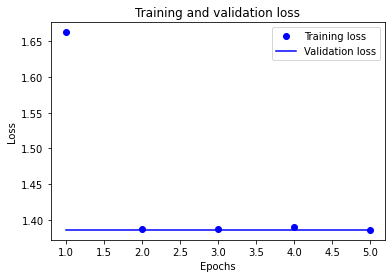

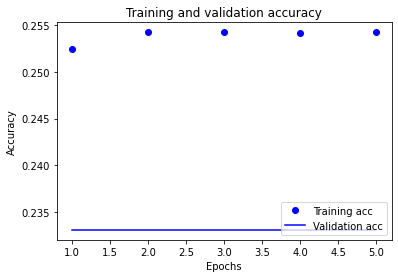

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [101]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.figure()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
plt.figure()

array([[0.49475974, 0.49136728, 0.49177587, 0.48681757]], dtype=float32)

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
)



### Predicciones

In [119]:
examples = [
  "public static void main strings args",
  "i 0 print ",
  "namespace class Console WriteLine"

]

export_model.predict(examples)

array([[0.49470863, 0.49166495, 0.4918223 , 0.48686326],
       [0.4947133 , 0.49140847, 0.49186164, 0.4869967 ],
       [0.49472728, 0.49144357, 0.4919317 , 0.48684222]], dtype=float32)

Como vemos este modelo no es demasiado bueno...